In [1]:
import pandas as pd
import re
import pymysql
from tqdm import tqdm
from glob import glob
import queue
import yaml
import pickle

with open('../config.yml') as f:
    config = yaml.load(f)

con = pymysql.connect(host=config['MYSQL_HOST'], user=config['MYSQL_USER'], passwd=config['MYSQL_PASSWD'], 
                      db=config['MYSQL_DB'])

cur = con.cursor()

aminoacid_to_single_letter = {
    'Ala': 'A','Arg': 'R','Asn': 'N','Asp': 'D','Asx': 'B',
    'Cys': 'C','Glu': 'E','Gln': 'Q','Glx': 'Z','Gly': 'G','His': 'H',
    'Ile': 'I','Leu': 'L','Lys': 'K','Met': 'M','Phe': 'F','Pro': 'P',
    'Ser': 'S','Thr': 'T','Trp': 'W','Tyr': 'Y','Val': 'V',
}

In [2]:
df_cosmic_pathogenic = pd.read_sql("""SELECT accession_number, sample_name, fathmm_prediction, fathmm_score, id_sample, id_tumour, primary_site, primary_histology, mutation_id, mutation_cds, mutation_aa, snp, position, mutation_somatic_status FROM CosmicMutantExport as cosmic
                    WHERE fathmm_prediction='PATHOGENIC' GROUP BY cosmic.cme_id""", con)

df_cosmic_pathogenic_unique = df_cosmic_pathogenic.apply(lambda x: x['accession_number']+'-'+x['mutation_aa'], axis=1)\
                    .drop_duplicates()

In [3]:
df_dbsnp = pd.read_sql("""SELECT Feature, HGVSp FROM dbsnp""", con)

df_dbsnp_unique = df_dbsnp.apply(lambda x: x['Feature']+'-'+x['HGVSp'].split(':')[1], axis=1)\
                    .drop_duplicates()
for from_str, to_str in aminoacid_to_single_letter.items():
    df_dbsnp_unique = df_dbsnp_unique.apply(lambda x: x.replace(from_str, to_str))


In [4]:
df_gnomad = pd.read_sql("""SELECT gnomad.* FROM gnomad GROUP BY gnomad.id""", 
                        con)

df_gnomad_unique = df_gnomad.apply(lambda x: x['canonical_transcript']+'-'+x['variation'], axis=1)\
                    .drop_duplicates()
for from_str, to_str in aminoacid_to_single_letter.items():
    df_gnomad_unique = df_gnomad_unique.apply(lambda x: x.replace(from_str, to_str))


In [ ]:
print('Number of variations present in both gnomad, cosmic and dbsnp', len(set(df_gnomad_unique.tolist()).intersection(
                set(df_cosmic_pathogenic_unique.tolist())).intersection(df_dbsnp_unique.tolist())), \
                '\nnumber of distinct enst-variation pairs in gnomad',df_gnomad_unique.shape[0],\
                '\nnumber of distinct enst-variation pairs in cosmic among pathogenic variations', \
                df_cosmic_pathogenic_unique.shape[0],
                '\nnumber of distinct enst-variation pairs in dbsnp', df_dbsnp_unique.shape[0]
        )


In [6]:
df_clinvar = pd.read_sql("""SELECT clinvar.*, cdb_enst.db_id AS acc_id FROM clinvar INNER JOIN convart_gene_to_db AS cdb ON 
                    cdb.db_id = clinvar.np_id INNER JOIN convart_gene_to_db AS cdb_enst ON 
                    cdb_enst.convart_gene_id = cdb.convart_gene_id AND cdb_enst.db = 'ENST'
                    GROUP BY clinvar.clinvar_id""", con)
df_clinvar_unique = df_clinvar.apply(lambda x: x['acc_id']+'-'+x['variation'], axis=1)\
                    .drop_duplicates()
for from_str, to_str in aminoacid_to_single_letter.items():
    df_clinvar_unique = df_clinvar_unique.apply(lambda x: x.replace(from_str, to_str))

df_clinvar_unique = df_clinvar_unique.apply(lambda x: x.replace('(', ''))
df_clinvar_unique = df_clinvar_unique.apply(lambda x: x.replace(')', ''))

In [ ]:
print('Clinvar - Cosmic comparison:')
print('Number of matching variations in both databases', len(set(df_clinvar_unique.tolist()).intersection(
                set(df_cosmic_pathogenic_unique.tolist()))), \
                '\nnumber of distinct enst-variation pairs in clinvar',df_clinvar_unique.shape[0],\
                '\nnumber of distinct enst-variation pairs in cosmic among pathogenic variations', \
                df_cosmic_pathogenic_unique.shape[0],
        )

In [7]:

sets = [df_cosmic_pathogenic_unique, df_clinvar_unique, df_gnomad_unique, df_dbsnp_unique]

with open("sets.pkl", "wb") as f:
    pickle.dump(sets, f)

In [8]:
with open("sets.pkl", "rb") as f:
    sets = pickle.load(f)

In [13]:
import venn
from os import path
from matplotlib import pyplot as plt

fig = plt.figure(num=None, figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')
sets = [set(x) for x in sets]
venn_sets = venn.get_labels(sets)

/home/kaplanlab/.local/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"


<Figure size 960x960 with 0 Axes>

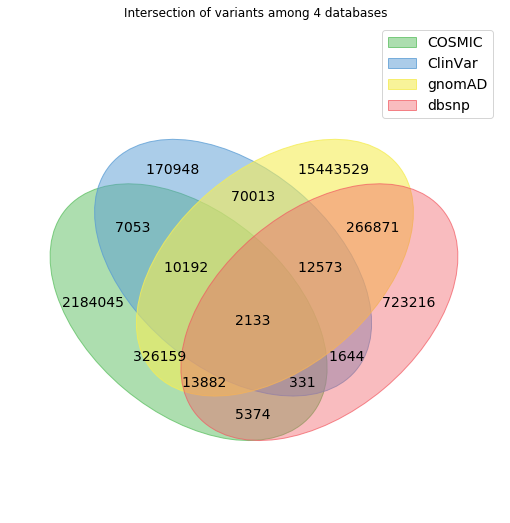

In [15]:

out = venn.venn4(venn_sets, 
              names=['COSMIC', 'ClinVar', 'gnomAD', 'dbsnp'])

#for text in out.set_labels:
#    text.set_fontsize(20)
#for text in out.subset_labels:
#    text.set_fontsize(20)
#    text.set_text(format(int(text.get_text()), ',d'))
plt.title('Intersection of variants among 4 databases')
plt.savefig(path.join(config['PROJECT'], 'figures', 'venn_diagram_of_variants_from_4_databases.png'))
plt.show()